In [1]:
#%%
rm(list = ls())
library(LalRUtils)
libreq(data.table, tidyverse, anytime, patchwork, plotly, zoo)
theme_set(lal_plot_theme())
options(repr.plot.width = 15, repr.plot.height=12)

     wants        loaded
[1,] "data.table" TRUE  
[2,] "tidyverse"  TRUE  
[3,] "anytime"    TRUE  
[4,] "patchwork"  TRUE  
[5,] "plotly"     TRUE  
[6,] "zoo"        TRUE  


# NYT county level time series 

In [2]:
#%% check timestamp at https://github.com/nytimes/covid-19-data
df = fread("https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties.csv")
df[, d := anydate(date)]
setorder(df, state, county, date)
df[order(-date)] %>% head

date       county  state   fips cases deaths d         
1 2020-04-05 Autauga Alabama 1001 12    0      2020-04-05
2 2020-04-05 Baldwin Alabama 1003 34    1      2020-04-05
3 2020-04-05 Barbour Alabama 1005  2    0      2020-04-05
4 2020-04-05 Bibb    Alabama 1007  7    0      2020-04-05
5 2020-04-05 Blount  Alabama 1009 10    0      2020-04-05
6 2020-04-05 Bullock Alabama 1011  2    0      2020-04-05

In [3]:
bay_counties = c(
  "San Francisco",
  "San Mateo",
  "Santa Clara",
  "Alameda",
  "Contra Costa",
  "Marin"
)

In [4]:
df[,  `:=`(
  new_cases  = cases - shift(cases),
  new_deaths = deaths - shift(deaths)
), by = .(state, county)]
df = df[d >= "2020-03-01"]
smoothvars = c("cases", "deaths", "new_cases", "new_deaths")

df[, paste0("rm3_", smoothvars) := lapply(.SD, rollmean, k = 3, fill = NA, na.pad = T), 
   by = .(state, county), .SDcols = smoothvars]

## CA: Bay Area vs the rest

In [5]:
ca_all = df[state == "California"]
ca_all[, bayrea := case_when(
    county %in% bay_counties ~ "Bay",
    TRUE ~ "Elsewhere")]

vars = c("cases", "deaths", "new_cases", "new_deaths")

ca_div = ca_all[, lapply(.SD, sum, na.rm = T), 
   by = .(bayrea, d), .SDcols = vars]
smoothvars = c("cases", "deaths", "new_cases", "new_deaths")

ca_div[, paste0("rm3_", smoothvars) := lapply(.SD, rollmean, k = 3, fill = NA, na.pad = T), 
   by = .(bayrea), .SDcols = smoothvars]
ca_div %>% head

bayrea d          cases deaths new_cases new_deaths rm3_cases rm3_deaths
1 Bay    2020-03-01 12    0      3         0             NA     NA        
2 Bay    2020-03-02 15    0      2         0          15.33      0        
3 Bay    2020-03-03 19    0      3         0          18.67      0        
4 Bay    2020-03-04 22    0      3         0          23.67      0        
5 Bay    2020-03-05 30    0      8         0          30.00      0        
6 Bay    2020-03-06 38    0      8         0          40.00      0        
  rm3_new_cases rm3_new_deaths
1     NA        NA            
2  2.667         0            
3  2.667         0            
4  4.667         0            
5  6.333         0            
6 10.000         0

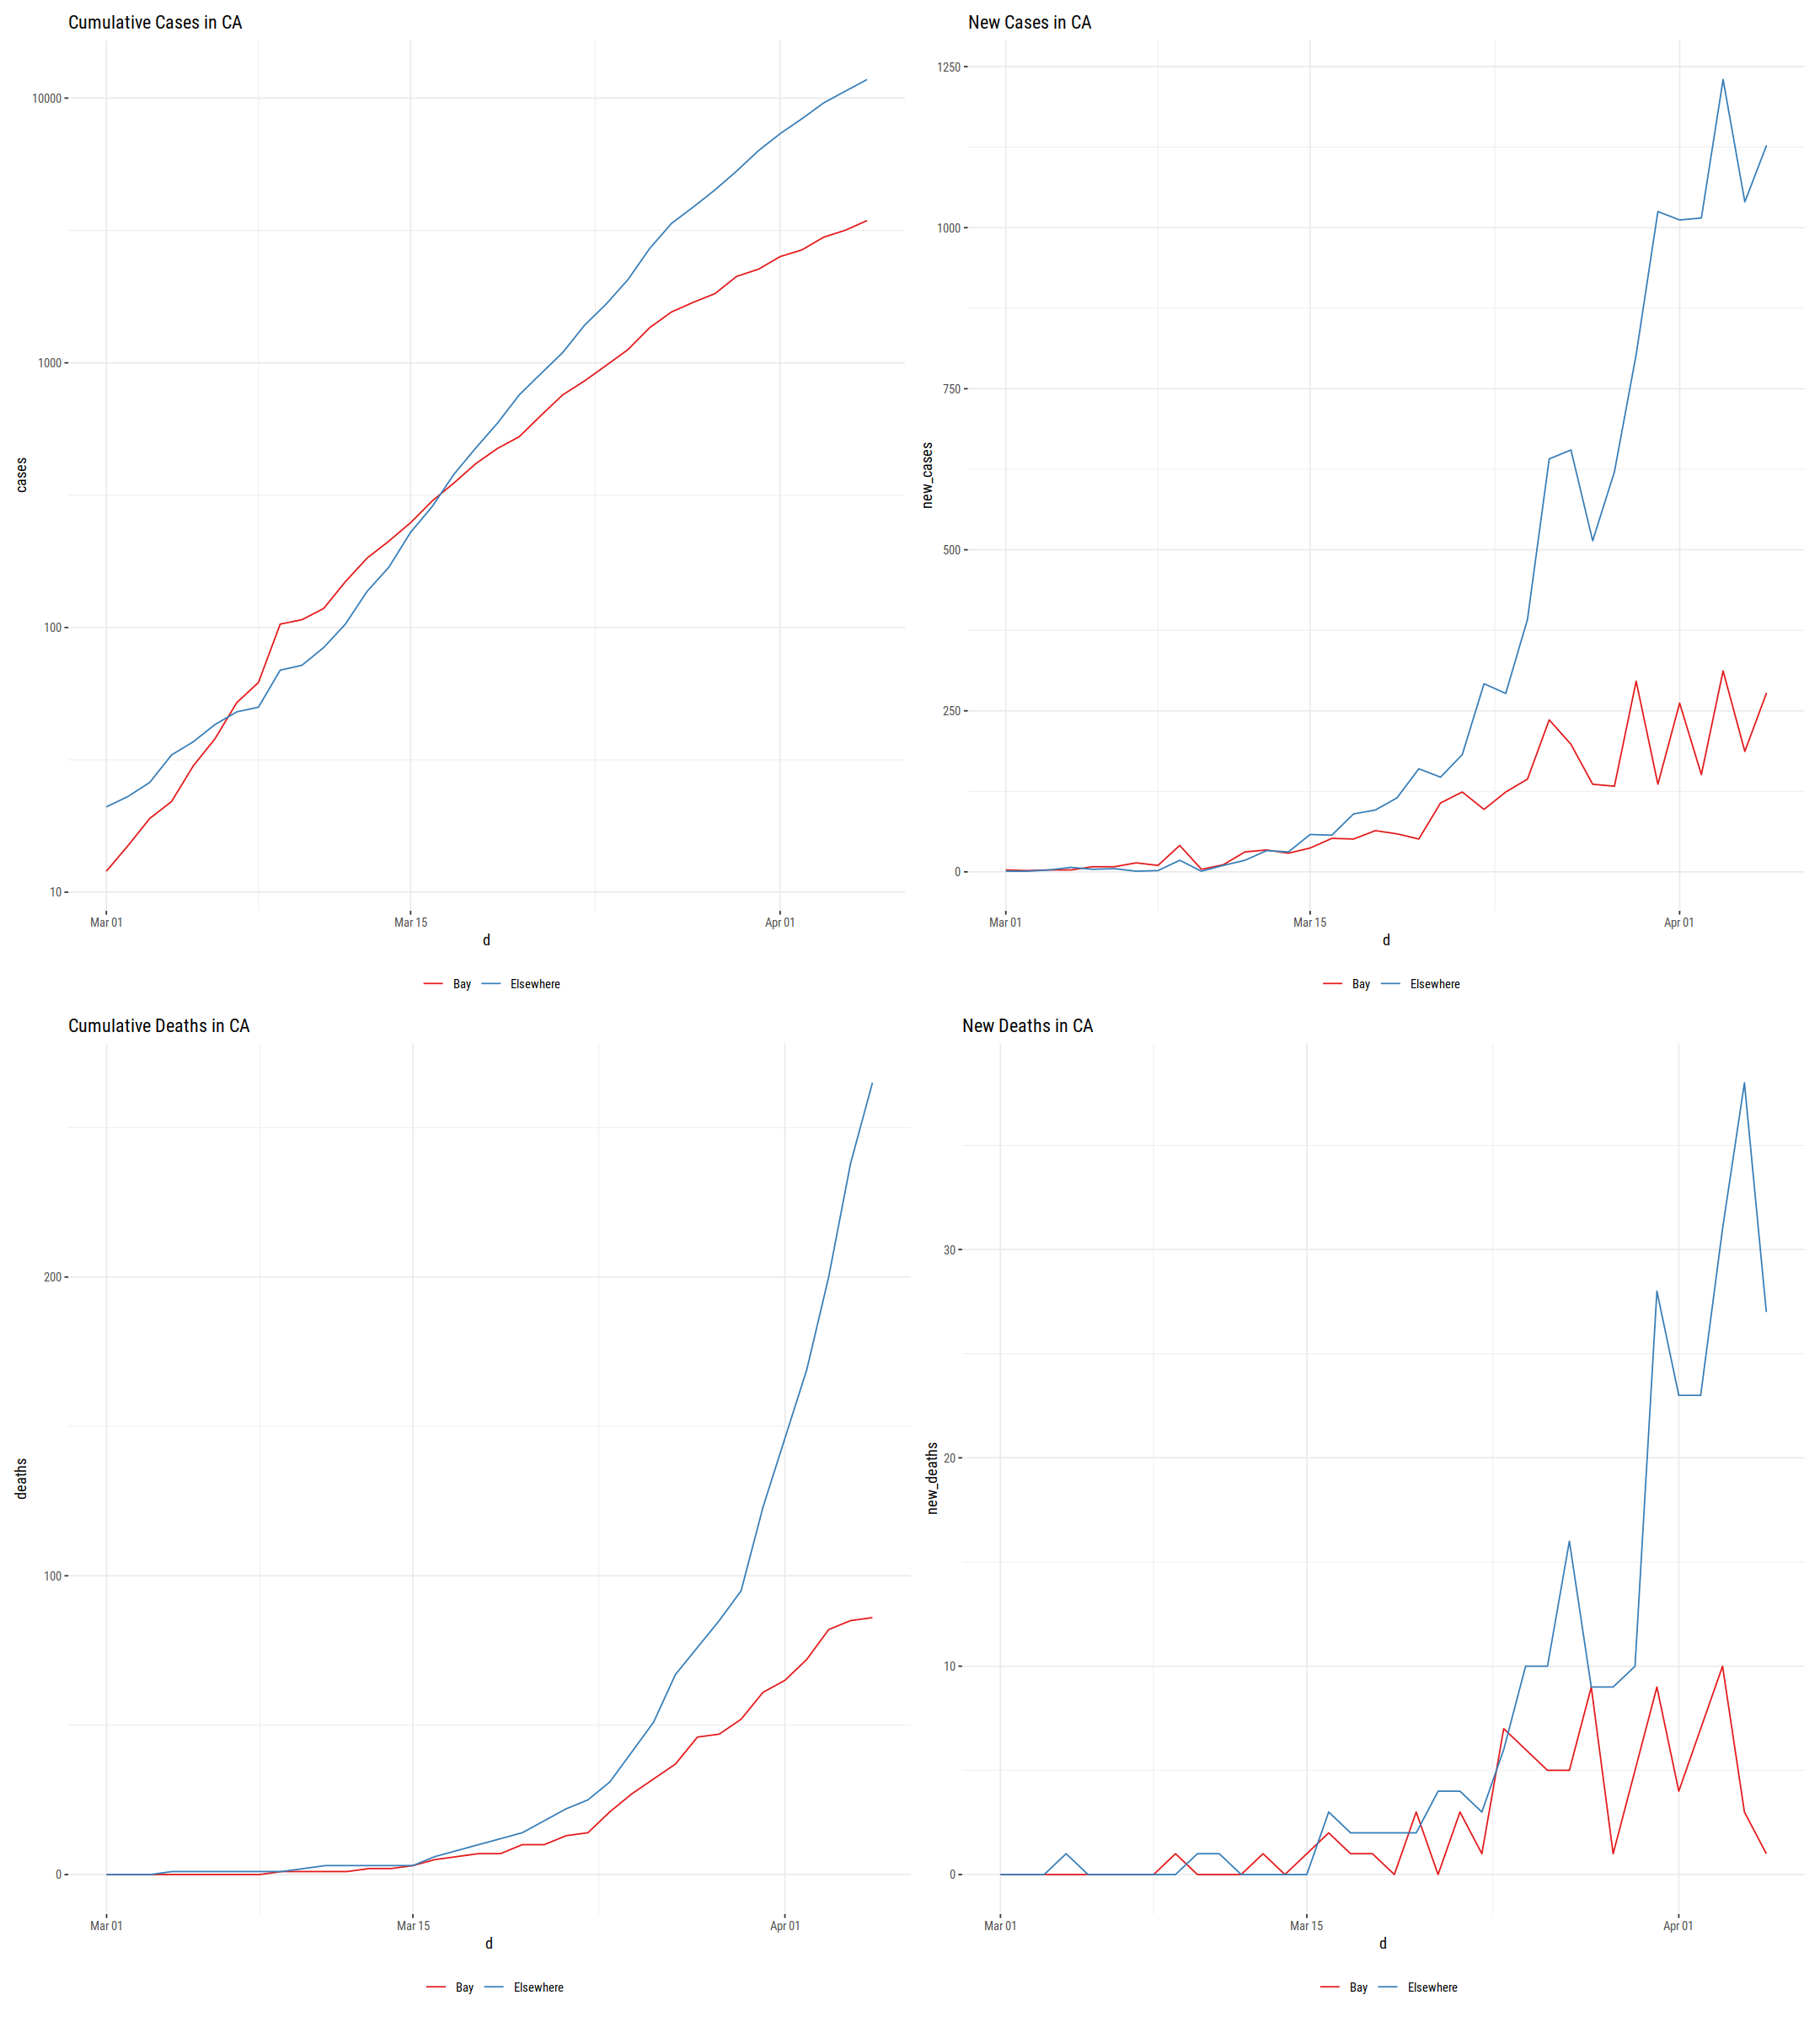

In [6]:
p1 = ggplot(ca_div, aes(x = d, y = cases, group = as.factor(bayrea), colour = as.factor(bayrea))) +
    geom_line() + scale_y_log10()+
  scale_colour_brewer(palette = 'Set1') +
    ggtitle("Cumulative Cases in CA")
p2 = ggplot(ca_div, aes(x = d, y = new_cases, group = as.factor(bayrea), colour = as.factor(bayrea))) +
  geom_line() +
  scale_colour_brewer(palette = 'Set1') +
    ggtitle("New Cases in CA")

p3 = ggplot(ca_div, aes(x = d, y = deaths, group = as.factor(bayrea), colour = as.factor(bayrea))) +
  geom_line() +
  scale_colour_brewer(palette = 'Set1') +
    ggtitle("Cumulative Deaths in CA")
p4 = ggplot(ca_div, aes(x = d, y = new_deaths, group = as.factor(bayrea), colour = as.factor(bayrea))) +
  geom_line() +
  scale_colour_brewer(palette = 'Set1') +
    ggtitle("New Deaths in CA")

options(repr.plot.width = 18, repr.plot.height=20)
(p1 | p2) / (p3 | p4)

## Counties within the Bay Area

In [7]:
bayrea_mar = df[county %in% bay_counties & state == "California" & d>= "2020-03-01"]
bayrea_mar %>% glimpse

Rows: 213
Columns: 13
$ date           <chr> "2020-03-01", "2020-03-02", "2020-03-03", "2020-03-04"…
$ county         <chr> "Alameda", "Alameda", "Alameda", "Alameda", "Alameda",…
$ state          <chr> "California", "California", "California", "California"…
$ fips           <int> 6001, 6001, 6001, 6001, 6001, 6001, 6001, 6001, 6001, …
$ cases          <int> 1, 1, 2, 2, 2, 3, 3, 3, 24, 25, 25, 29, 29, 29, 37, 40…
$ deaths         <int> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, …
$ d              <date> 2020-03-01, 2020-03-02, 2020-03-03, 2020-03-04, 2020-…
$ new_cases      <int> NA, 0, 1, 0, 0, 1, 0, 0, 21, 1, 0, 4, 0, 0, 8, 3, 9, 4…
$ new_deaths     <int> NA, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,…
$ rm3_cases      <dbl> NA, 1.333, 1.667, 2.000, 2.333, 2.667, 3.000, 10.000, …
$ rm3_deaths     <dbl> NA, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.…
$ rm3_new_cases  <dbl> NA, NA, 0.3333, 0.3333, 0.3333, 0.3333, 0.3333, 7.0000…
$ rm3_new_deaths <dbl> NA, NA,

### Cases

Warning message:
“Removed 3 row(s) containing missing values (geom_path).”


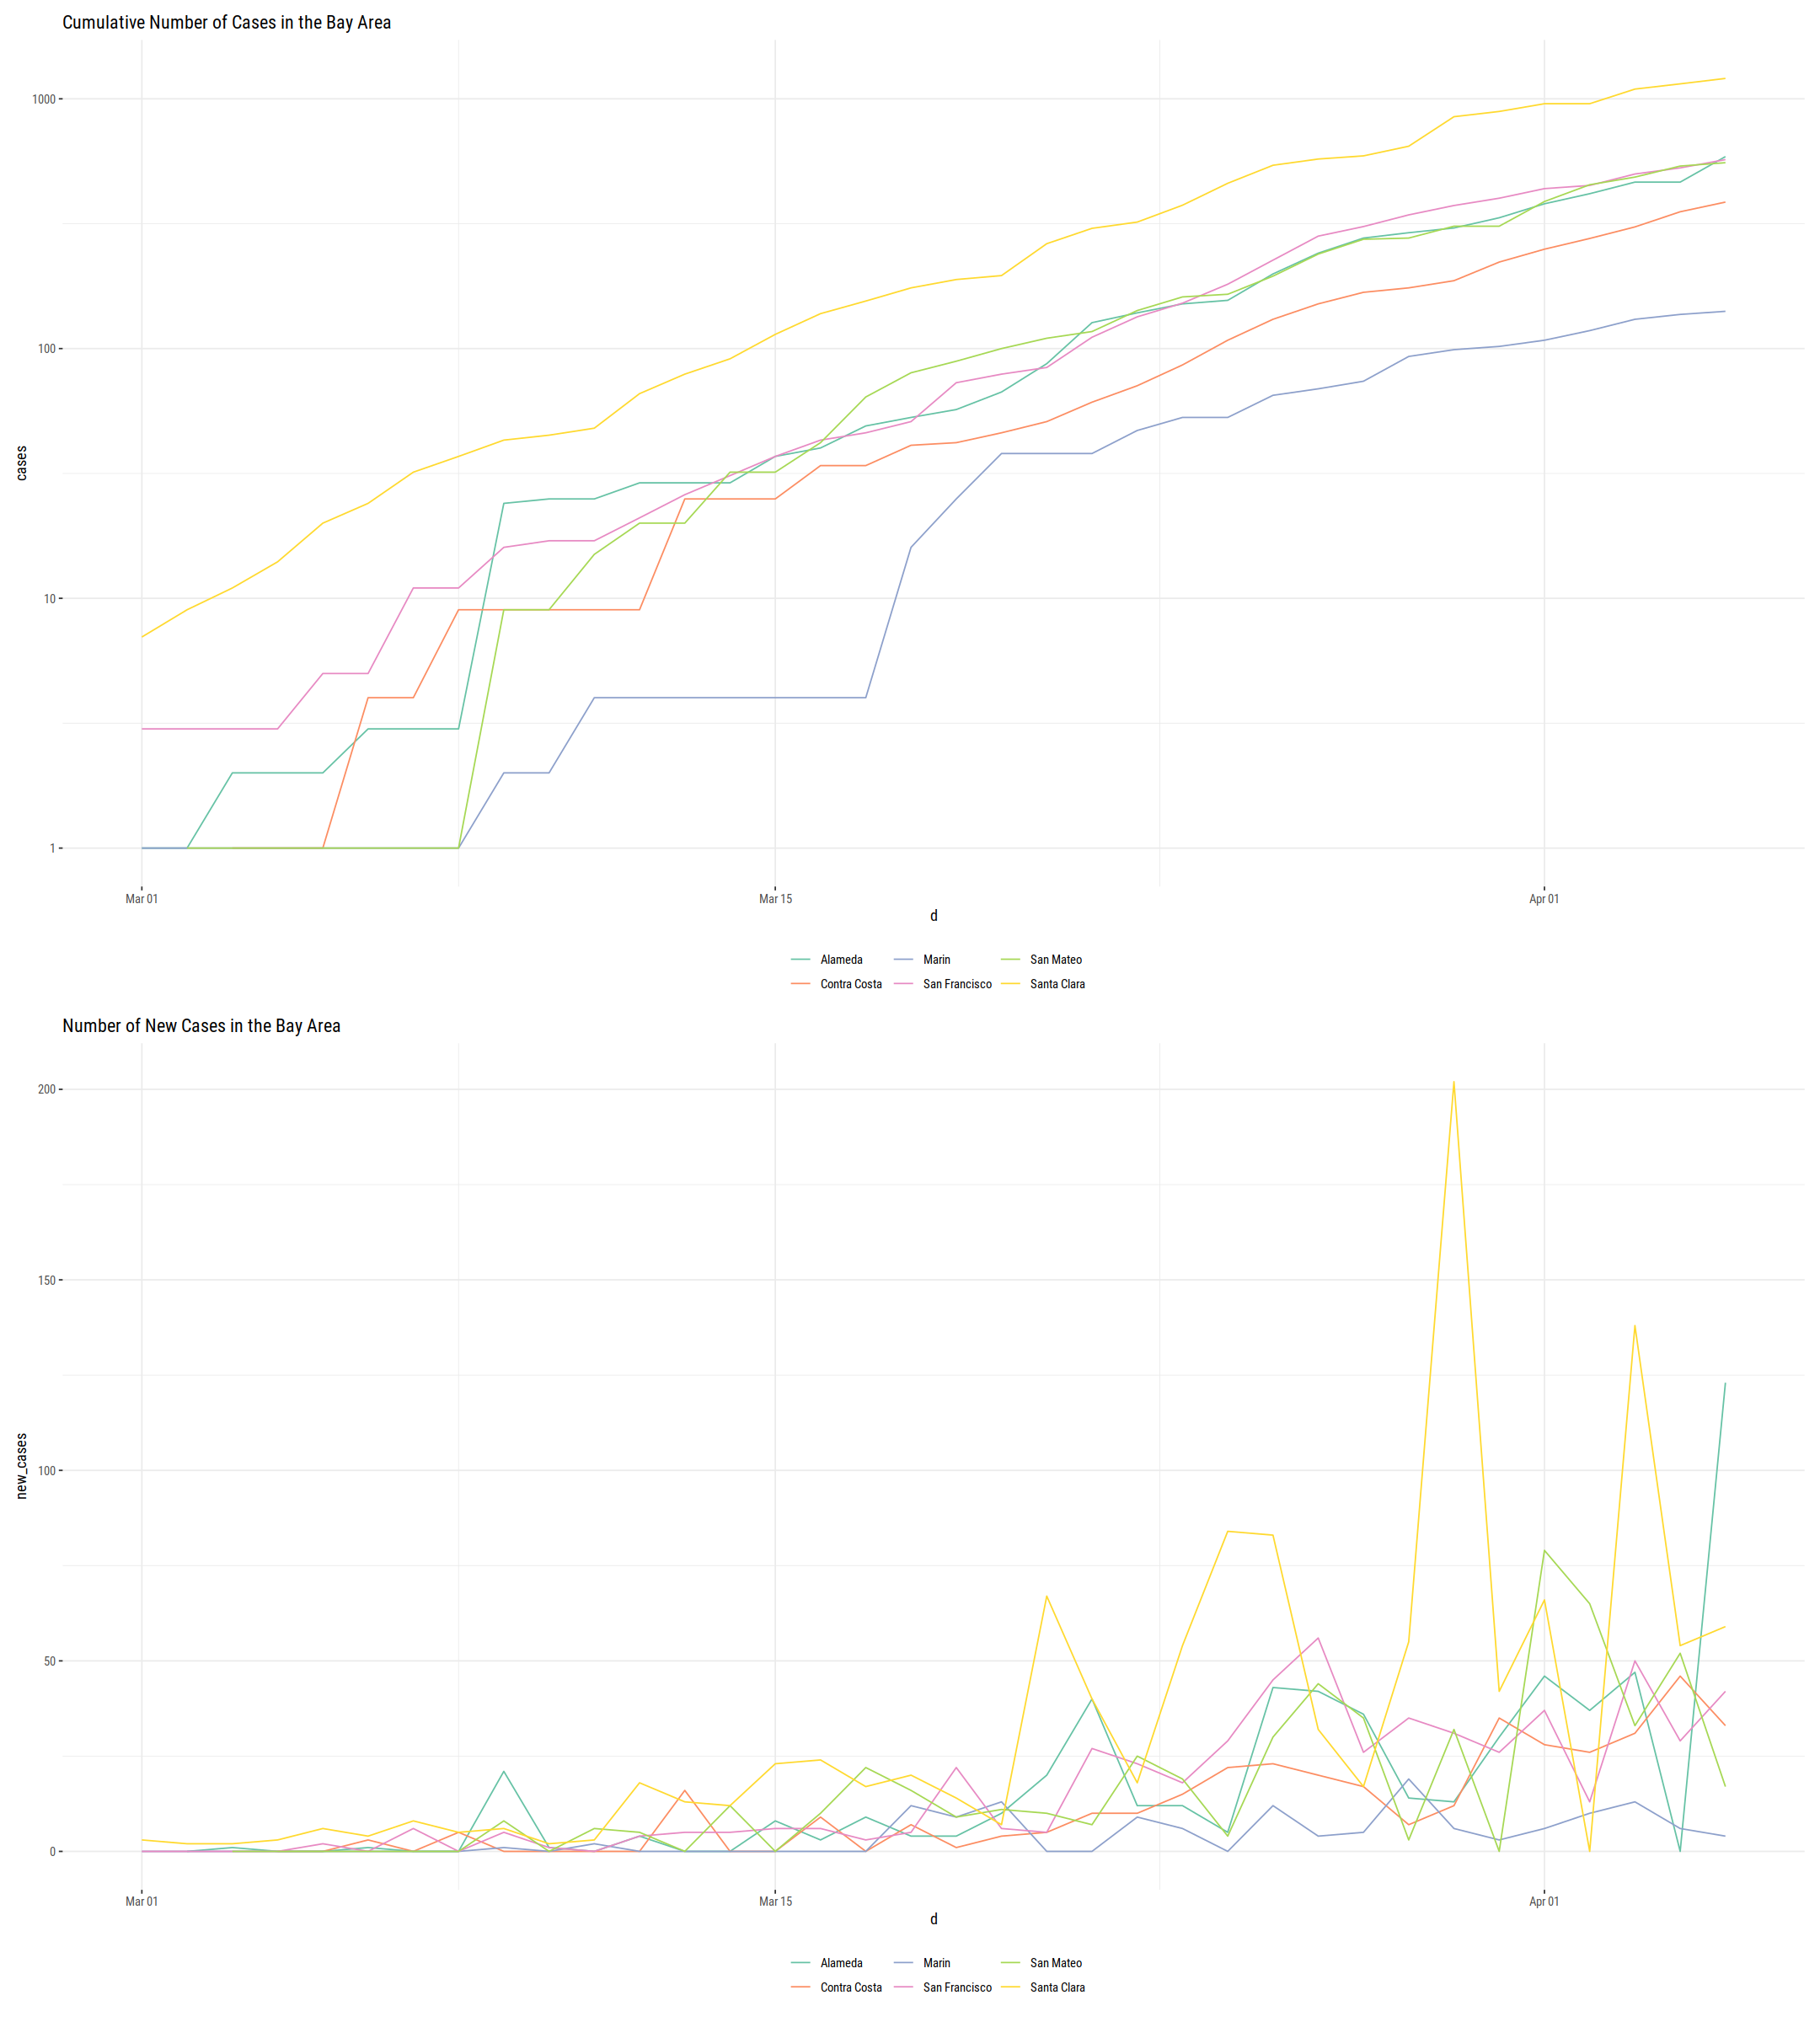

In [8]:
p1 = ggplot(bayrea_mar, aes(x = d, y = cases, group = county, colour = county)) +
  geom_line() +
  scale_y_log10() +
  scale_colour_brewer(palette = 'Set2') +
  ggtitle("Cumulative Number of Cases in the Bay Area")

p2 = ggplot(bayrea_mar, aes(x = d, y = new_cases, group = county, colour = county)) +
  geom_line() +
  scale_colour_brewer(palette = 'Set2') +
  ggtitle("Number of New Cases in the Bay Area")
(p1 / p2)

Warning message:
“Removed 12 row(s) containing missing values (geom_path).”
Warning message:
“Removed 15 row(s) containing missing values (geom_path).”


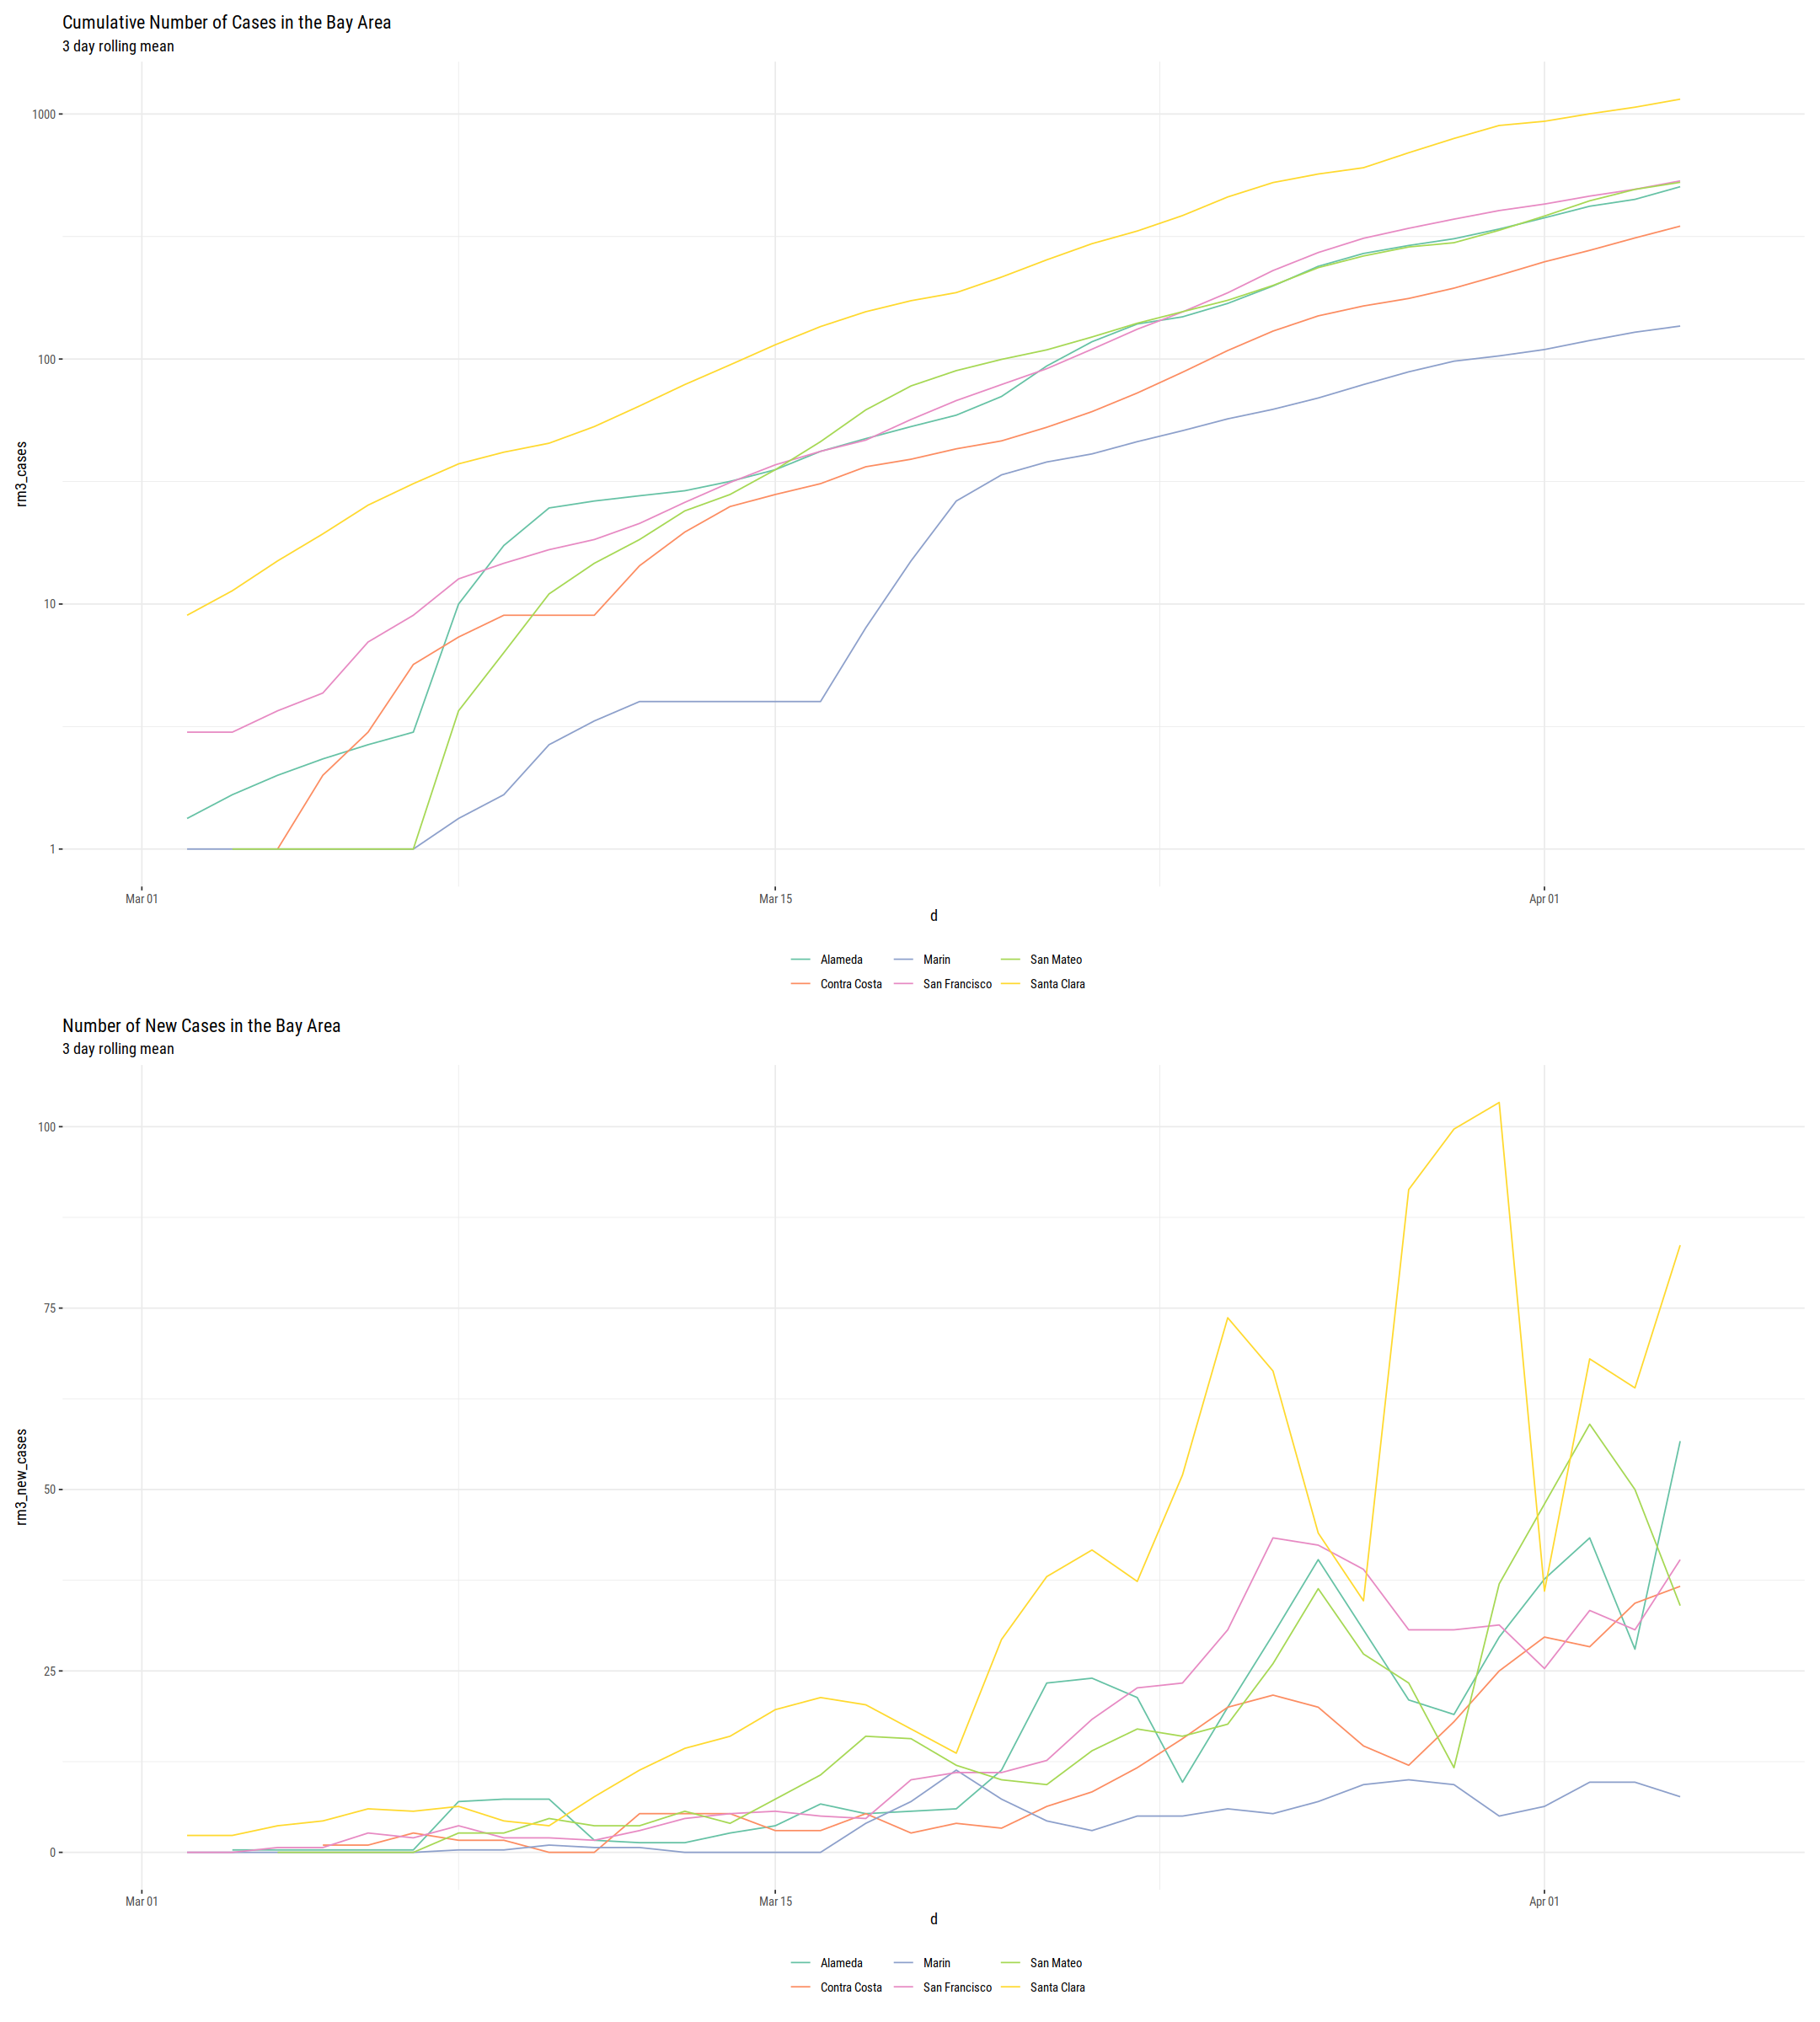

In [9]:
p1 = ggplot(bayrea_mar, aes(x = d, y = rm3_cases, group = county, colour = county)) +
  geom_line() +
  scale_y_log10() +
  scale_colour_brewer(palette = 'Set2') +
  labs(title = "Cumulative Number of Cases in the Bay Area", subtitle = '3 day rolling mean')

p2 = ggplot(bayrea_mar, aes(x = d, y = rm3_new_cases, group = county, colour = county)) +
  geom_line() +
  scale_colour_brewer(palette = 'Set2') +
  labs(title = "Number of New Cases in the Bay Area", subtitle = '3 day rolling mean')
(p1 / p2)

In [10]:
embed_notebook(ggplotly(p2))

<iframe src="data:text/html;charset=utf-8;base64,PCFET0NUWVBFIGh0bWw+CjxodG1sPgo8aGVhZD4KPG1ldGEgY2hhcnNldD0idXRmLTgiIC8+Cjx0aXRsZT5wbG90bHk8L3RpdGxlPgo8c2NyaXB0PihmdW5jdGlvbigpIHsKICAvLyBJZiB3aW5kb3cuSFRNTFdpZGdldHMgaXMgYWxyZWFkeSBkZWZpbmVkLCB0aGVuIHVzZSBpdDsgb3RoZXJ3aXNlIGNyZWF0ZSBhCiAgLy8gbmV3IG9iamVjdC4gVGhpcyBhbGxvd3MgcHJlY2VkaW5nIGNvZGUgdG8gc2V0IG9wdGlvbnMgdGhhdCBhZmZlY3QgdGhlCiAgLy8gaW5pdGlhbGl6YXRpb24gcHJvY2VzcyAodGhvdWdoIG5vbmUgY3VycmVudGx5IGV4aXN0KS4KICB3aW5kb3cuSFRNTFdpZGdldHMgPSB3aW5kb3cuSFRNTFdpZGdldHMgfHwge307CgogIC8vIFNlZSBpZiB3ZSdyZSBydW5uaW5nIGluIGEgdmlld2VyIHBhbmUuIElmIG5vdCwgd2UncmUgaW4gYSB3ZWIgYnJvd3Nlci4KICB2YXIgdmlld2VyTW9kZSA9IHdpbmRvdy5IVE1MV2lkZ2V0cy52aWV3ZXJNb2RlID0KICAgICAgL1xidmlld2VyX3BhbmU9MVxiLy50ZXN0KHdpbmRvdy5sb2NhdGlvbik7CgogIC8vIFNlZSBpZiB3ZSdyZSBydW5uaW5nIGluIFNoaW55IG1vZGUuIElmIG5vdCwgaXQncyBhIHN0YXRpYyBkb2N1bWVudC4KICAvLyBOb3RlIHRoYXQgc3RhdGljIHdpZGdldHMgY2FuIGFwcGVhciBpbiBib3RoIFNoaW55IGFuZCBzdGF0aWMgbW9kZXMsIGJ1dAogIC8vIG9idmlvdXNseSwgU2hpbnkgd2lkZ2V0cyBjYW4gb25seSBhcHBlYXIgaW4gU2hpbnkgYXBwcy9kb2N1bWVudHMuCiAgdmFyIHNoaW55TW9kZSA9IHdpbmRvdy5IVE1MV2lkZ2V0cy5zaGlueU1vZGUgPQogICAgICB0eXBlb2Yod2luZG93LlNoaW55KSAhPT0gInVuZGVmaW5lZCIgJiYgISF3aW5kb3cuU2hpbnkub3V0cHV0QmluZGluZ3M7CgogIC8vIFdlIGNhbid0IGNvdW50IG9uIGpRdWVyeSBiZWluZyBhdmFpbGFibGUsIHNvIHdlIGltcGxlbWVudCBvdXIgb3duCiAgLy8gdmVyc2lvbiBpZiBuZWNlc3NhcnkuCiAgZnVuY3Rpb24gcXVlcnlTZWxlY3RvckFsbChzY29wZSwgc2VsZWN0b3IpIHsKICAgIGlmICh0eXBlb2YoalF1ZXJ5KSAhPT0gInVuZGVmaW5lZCIgJiYgc2NvcGUgaW5zdGFuY2VvZiBqUXVlcnkpIHsKICAgICAgcmV0dXJuIHNjb3BlLmZpbmQoc2VsZWN0b3IpOwogICAgfQogICAgaWYgKHNjb3BlLnF1ZXJ5U2VsZWN0b3JBbGwpIHsKICAgICAgcmV0dXJuIHNjb3BlLnF1ZXJ5U2VsZWN0b3JBbGwoc2VsZWN0b3IpOwogICAgfQogIH0KCiAgZnVuY3Rpb24gYXNBcnJheSh2YWx1ZSkgewogICAgaWYgKHZhbHVlID09PSBudWxsKQogICAgICByZXR1cm4gW107CiAgICBpZiAoJC5pc0FycmF5KHZhbHVlKSkKICAgICAgcmV0dXJuIHZhbHVlOwogICAgcmV0dXJuIFt2YWx1ZV07CiAgfQoKICAvLyBJbXBsZW1lbnQgalF1ZXJ5J3MgZXh0ZW5kCiAgZnVuY3Rpb24gZXh0ZW5kKHRhcmdldCAvKiwgLi4uICovKSB7CiAgICBpZiAoYXJndW1lbnRzLmxlbmd0aCA9PSAxKSB7CiAgICAgIHJldHVybiB0YXJnZXQ7CiAgICB9CiAgICBmb3IgKHZhciBpID0gMTsgaSA8IGFyZ3VtZW50cy5sZW5ndGg7IGkrKykgewogICAgICB2YXIgc291cmNlID0gYXJndW1lbnRzW2ldOwogICAgICBmb3IgKHZhciBwcm9wIGluIHNvdXJjZSkgewogICAgICAgIGlmIChzb3VyY2UuaGFzT3duUHJvcGVydHkocHJvcCkpIHsKICAgICAgICAgIHRhcmdldFtwcm9wXSA9IHNvdXJjZVtwcm9wXTsKICAgICAgICB9CiAgICAgIH0KICAgIH0KICAgIHJldHVybiB0YXJnZXQ7CiAgfQoKICAvLyBJRTggZG9lc24ndCBzdXBwb3J0IEFycmF5LmZvckVhY2guCiAgZnVuY3Rpb24gZm9yRWFjaCh2YWx1ZXMsIGNhbGxiYWNrLCB0aGlzQXJnKSB7CiAgICBpZiAodmFsdWVzLmZvckVhY2gpIHsKICAgICAgdmFsdWVzLmZvckVhY2goY2FsbGJhY2ssIHRoaXNBcmcpOwogICAgfSBlbHNlIHsKICAgICAgZm9yICh2YXIgaSA9IDA7IGkgPCB2YWx1ZXMubGVuZ3RoOyBpKyspIHsKICAgICAgICBjYWxsYmFjay5jYWxsKHRoaXNBcmcsIHZhbHVlc1tpXSwgaSwgdmFsdWVzKTsKICAgICAgfQogICAgfQogIH0KCiAgLy8gUmVwbGFjZXMgdGhlIHNwZWNpZmllZCBtZXRob2Qgd2l0aCB0aGUgcmV0dXJuIHZhbHVlIG9mIGZ1bmNTb3VyY2UuCiAgLy8KICAvLyBOb3RlIHRoYXQgZnVuY1NvdXJjZSBzaG91bGQgbm90IEJFIHRoZSBuZXcgbWV0aG9kLCBpdCBzaG91bGQgYmUgYSBmdW5jdGlvbgogIC8vIHRoYXQgUkVUVVJOUyB0aGUgbmV3IG1ldGhvZC4gZnVuY1NvdXJjZSByZWNlaXZlcyBhIHNpbmdsZSBhcmd1bWVudCB0aGF0IGlzCiAgLy8gdGhlIG92ZXJyaWRkZW4gbWV0aG9kLCBpdCBjYW4gYmUgY2FsbGVkIGZyb20gdGhlIG5ldyBtZXRob2QuIFRoZSBvdmVycmlkZGVuCiAgLy8gbWV0aG9kIGNhbiBiZSBjYWxsZWQgbGlrZSBhIHJlZ3VsYXIgZnVuY3Rpb24sIGl0IGhhcyB0aGUgdGFyZ2V0IHBlcm1hbmVudGx5CiAgLy8gYm91bmQgdG8gaXQgc28gInRoaXMiIHdpbGwgd29yayBjb3JyZWN0bHkuCiAgZnVuY3Rpb24gb3ZlcnJpZGVNZXRob2QodGFyZ2V0LCBtZXRob2ROYW1lLCBmdW5jU291cmNlKSB7CiAgICB2YXIgc3VwZXJGdW5jID0gdGFyZ2V0W21ldGhvZE5hbWVdIHx8IGZ1bmN0aW9uKCkge307CiAgICB2YXIgc3VwZXJGdW5jQm91bmQgPSBmdW5jdGlvbigpIHsKICAgICAgcmV0dXJuIHN1cGVyRnVuYy5hcHBseSh0YXJnZXQsIGFyZ3VtZW50cyk7CiAgICB9OwogICAgdGFyZ2V0W21ldGhvZE5hbWVdID0gZnVuY1NvdXJjZShzdXBlckZ1bmNCb3VuZCk7CiAgfQoKICAvLyBBZGQgYSBtZXRob2QgdG8gZGVsZWdhdG9yIHRoYXQsIHdoZW4gaW52b2tlZCwgY2FsbHMKICAvLyBkZWxlZ2F0ZWUubWV0aG9kTmFtZS4gSWYgdGhlcmUgaXMgbm8gc3VjaCBtZXRob2Qgb24KICAvLyB0aGUgZGVsZWdhdGVlLCBidXQgdGhlcmUgd2FzIG9uZSBvbiBkZWxlZ2F0b3IgYmVmb3JlCiAgLy8gZGVsZWdhdGVNZXRob2Qgd2FzIGNhbGxlZCwgdGhlbiB

### Deaths

Warning message:
“Removed 12 row(s) containing missing values (geom_path).”
Warning message:
“Removed 15 row(s) containing missing values (geom_path).”


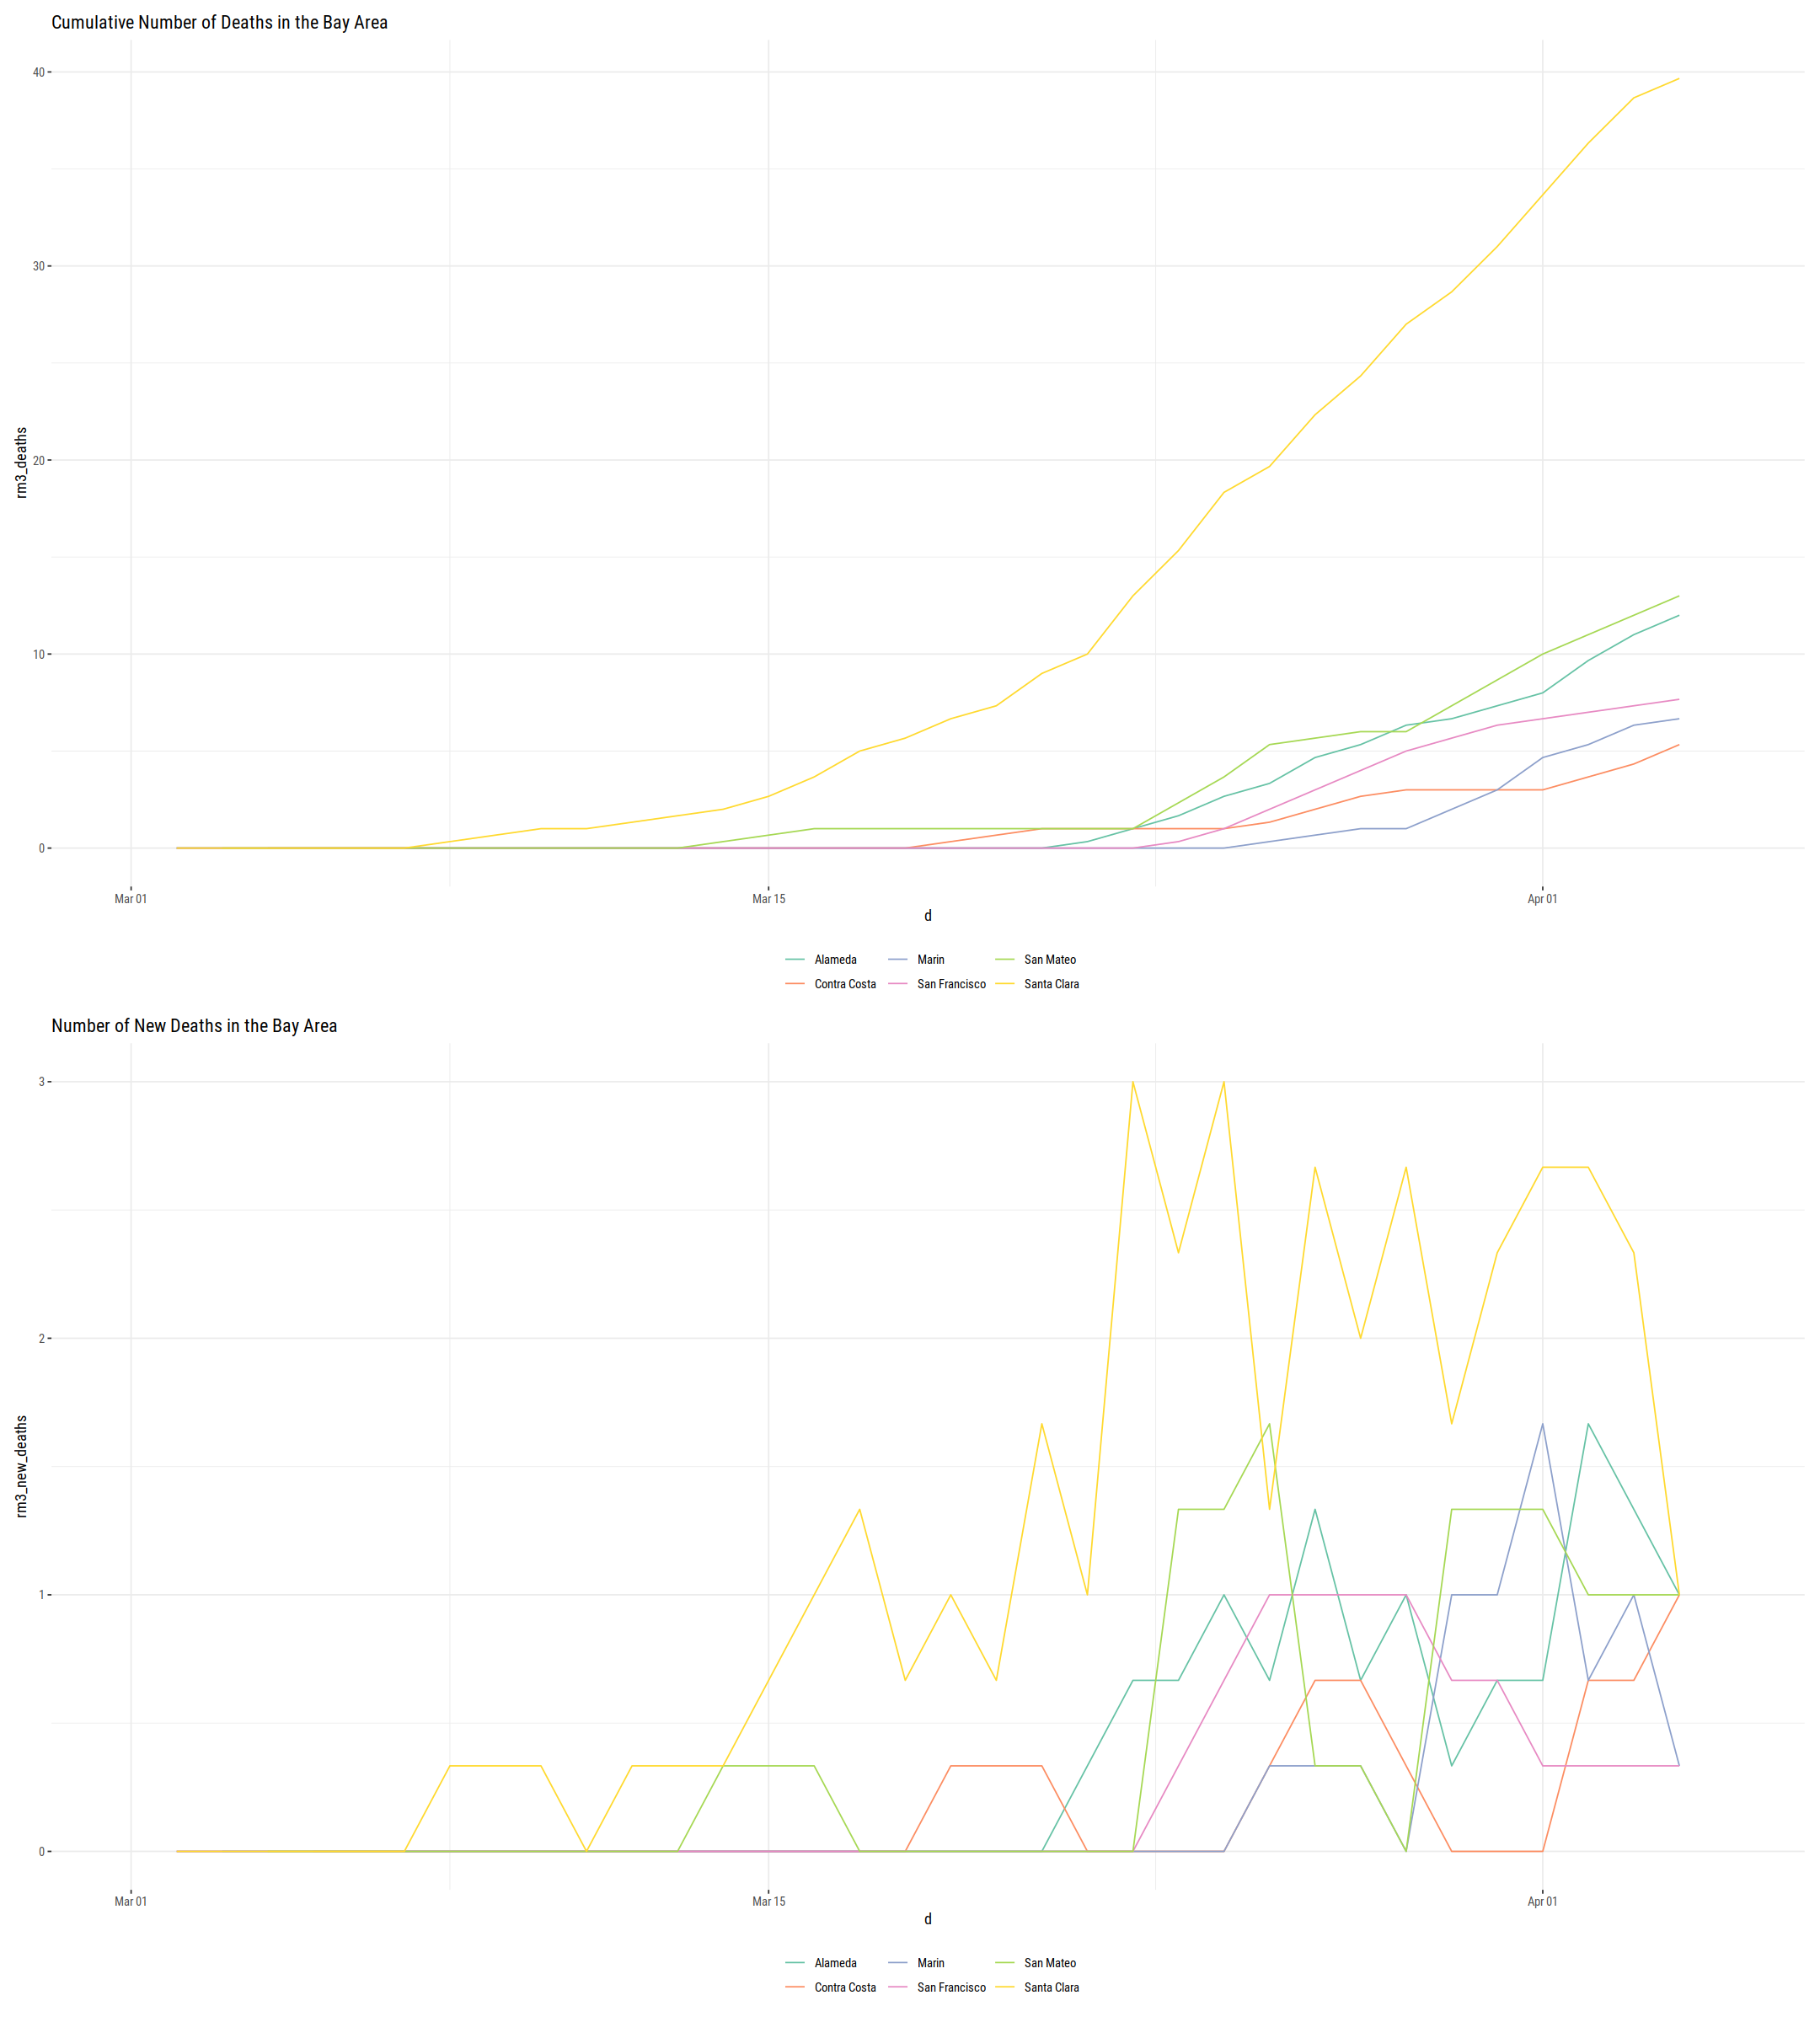

In [11]:
p1 = ggplot(bayrea_mar, aes(x = d, y = rm3_deaths, group = county, colour = county)) +
  geom_line() +
  scale_colour_brewer(palette = 'Set2') +
  ggtitle("Cumulative Number of Deaths in the Bay Area")
p2 = ggplot(bayrea_mar, aes(x = d, y = rm3_new_deaths, group = county, colour = county)) +
  geom_line() +
  scale_colour_brewer(palette = 'Set2') +
  ggtitle("Number of New Deaths in the Bay Area")
(p1 / p2)